### Importing all the required libraries

In [1]:

import imdlib as imd

import xarray as xr

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import cartopy.feature as cfeature

import cartopy.crs as ccrs


### Opening the dataset

In [2]:

ds = xr.open_dataset('rainfall_imd_data_1980_2022.nc')

ds


<xarray.Dataset>
Dimensions:  (time: 15706, lat: 129, lon: 135)
Coordinates:
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2022-12-31
Data variables:
    rain     (time, lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.7
    title:        IMD gridded data
    source:       https://imdpune.gov.in/
    history:      2023-06-17 15:07:51.727411 Python
    references:   
    comment:      
    crs:          epsg:4326

### Removing the NaN values

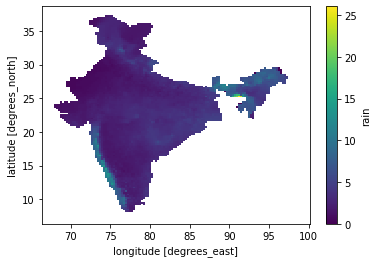

In [3]:

#### In IMD binary files, nan values are given by -999 value 

ds = ds.where(ds['rain'] != -999.)                                        # Remove NaN values

ds['rain'].mean('time').plot()


# PLOT 1 - Median and 90th percentile

### JJAS Plot for Median Rainfall in India (from 1980 - 2022)

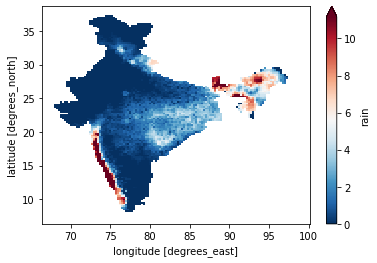

In [4]:

ds_JJAS_median = ds['rain'].where((ds['time.month'] > 5) & (ds['time.month'] < 10)).median('time')

ds_JJAS_median.plot(x = 'lon', y = 'lat', robust = True, cmap = plt.cm.RdBu_r)


### JJAS Plot for 90th Percentile

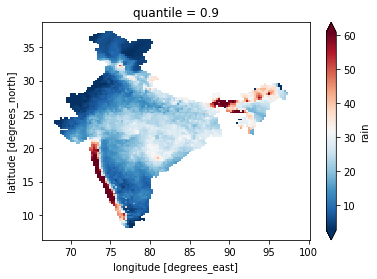

In [5]:

#import numpy as np

ds_JJAS_90th_perc = ds['rain'].where((ds['time.month'] > 5) & (ds['time.month'] < 10)).quantile(0.90, dim = 'time')

ds_JJAS_90th_perc.plot(x = 'lon', y = 'lat', robust = True, cmap = plt.cm.RdBu_r)


### JJAS Plot - Difference between 90th Percentile and Median

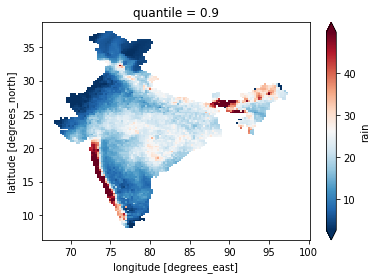

In [6]:

diff_90th_perc_and_median = ds_JJAS_90th_perc - ds_JJAS_median

diff_90th_perc_and_median.plot(x = 'lon', y = 'lat', robust = True, cmap = plt.cm.RdBu_r)


# PLOT 2 - Cumsum plot for J, J, A, S individually

In [7]:

### Selecting only the JJA months of the years

ds_JJAS = ds.sel(time=((ds.time.dt.month >= 6) & (ds.time.dt.month <= 9)))
ds_JJAS = ds_JJAS.where(ds_JJAS['rain'] != -999)

ds_JJAS


<xarray.Dataset>
Dimensions:  (time: 5246, lat: 129, lon: 135)
Coordinates:
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * time     (time) datetime64[ns] 1980-06-01 1980-06-02 ... 2022-09-30
Data variables:
    rain     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.7
    title:        IMD gridded data
    source:       https://imdpune.gov.in/
    history:      2023-06-17 15:07:51.727411 Python
    references:   
    comment:      
    crs:          epsg:4326

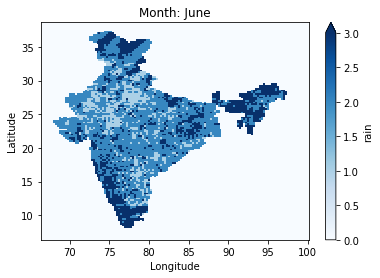

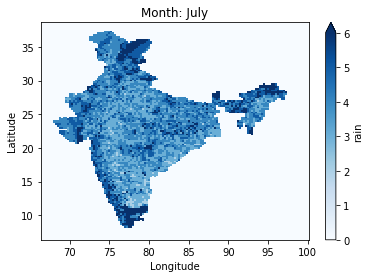

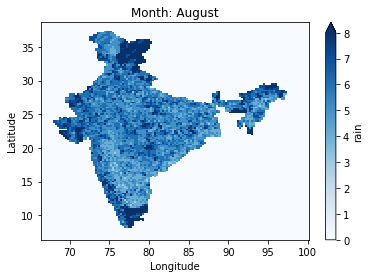

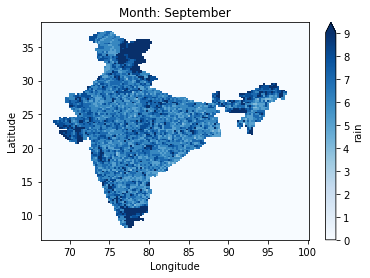

In [8]:

rain_90th_perc = ds_JJAS['rain'].quantile(0.9, dim='time')              # Calculate the 90th percentile of rainfall

rain_exceeds_90th_perc = ds_JJAS['rain'] > rain_90th_perc               # Create a binary mask for rainfall > 90th percentile

rain_exceeds_90th_perc = rain_exceeds_90th_perc.compute()               # Compute the variable 'rain_exceeds_90th_perc'


## Calculate the no. of events where there was consecutive rainfall exceeding 90th percentile

consecutive_events_yearwise = (rain_exceeds_90th_perc & (rain_exceeds_90th_perc == rain_exceeds_90th_perc.shift(time=1)) & 
            (rain_exceeds_90th_perc != rain_exceeds_90th_perc.shift(time=2))).groupby('time.year').cumsum(dim='time')


# Group the data by June, July, August, and September and get the max value

consecutive_events_JJAS = consecutive_events_yearwise.groupby('time.month').max(dim='time')


# Plotting

months = ['June', 'July', 'August', 'September']
for i, month in enumerate([6, 7, 8, 9]):
    plt.figure()
    subset = consecutive_events_JJAS.sel(month=month)
    subset.plot(x='lon', y='lat', cmap='Blues', robust=True)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Month: {}'.format(months[i]))
    plt.show()



# PLOT 3 - total no. of rainfall days Plot - J, J, A, S individually

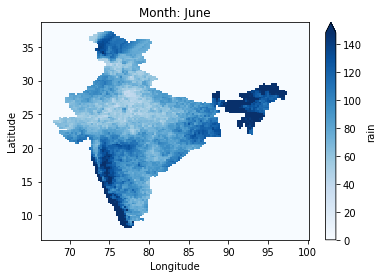

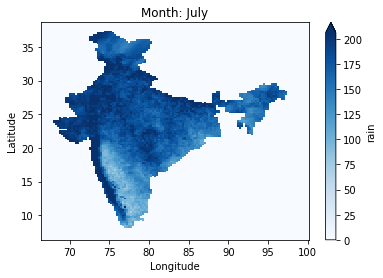

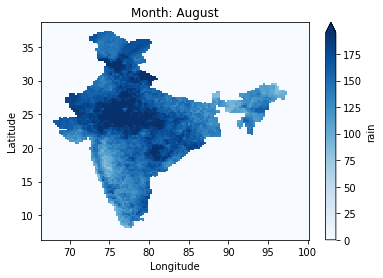

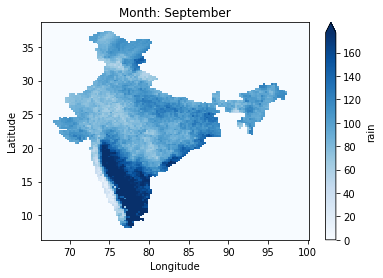

In [9]:

rain_90th_perc = ds_JJAS['rain'].quantile(0.9, dim='time')              # Calculate the 90th percentile of rainfall

rain_exceeds_90th_perc = ds_JJAS['rain'] > rain_90th_perc               # Create a binary mask for rainfall > 90th percentile

rain_exceeds_90th_perc = rain_exceeds_90th_perc.compute()               # Compute the variable 'rain_exceeds_90th_perc'


# Calculate the total number of days exceeding the 90th percentile by month

total_no_days_exceeds_90th_perc = rain_exceeds_90th_perc.groupby('time.month').sum(dim='time')


# Plotting

months = ['June', 'July', 'August', 'September']
for i, month in enumerate([6, 7, 8, 9]):
    plt.figure()
    subset = total_no_days_exceeds_90th_perc.sel(month=month)
    subset.plot(x='lon', y='lat', cmap='Blues', robust=True)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Month: {}'.format(months[i]))
    plt.show()


# PLOT 4 - Cumsum plot - for the whole data from 1980 - 2022

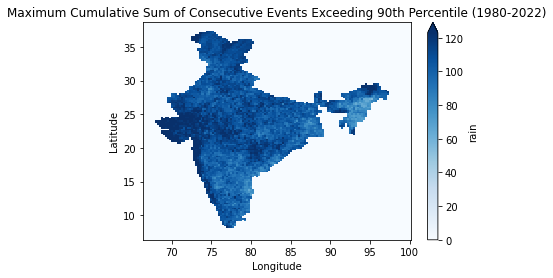

In [10]:

rain_90th_perc = ds_JJAS['rain'].quantile(0.9, dim='time')              # Calculate the 90th percentile of rainfall

rain_exceeds_90th_perc = ds_JJAS['rain'] > rain_90th_perc               # Create a binary mask for rainfall > 90th percentile

rain_exceeds_90th_perc = rain_exceeds_90th_perc.compute()               # Compute the variable 'rain_exceeds_90th_perc'


# Calculate the cumulative sum of consecutive events exceeding the 90th percentile

consecutive_events_cumsum = (rain_exceeds_90th_perc & (rain_exceeds_90th_perc == rain_exceeds_90th_perc.shift(time=1)) & 
                             (rain_exceeds_90th_perc != rain_exceeds_90th_perc.shift(time=2))).cumsum(dim='time')


# Calculate the maximum value in the cumulative sum

max_cumsum = consecutive_events_cumsum.max(dim='time')


# Plotting

plt.figure()
max_cumsum.plot(x='lon', y='lat', cmap='Blues', robust=True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Maximum Cumulative Sum of Consecutive Events Exceeding 90th Percentile (1980-2022)')
plt.show()


In [11]:


##############   WRONG   ###############################   WRONG   ########################   WRONG   ###################



# Specify the grid point of interest

lat = 21
lon = 79


# Specify the month and year of interest

month = 6
year = 2010


# 90th percentile

rain_90th_perc = ds_JJAS['rain'].quantile(0.9, dim='time')              # Calculate the 90th percentile of rainfall

rain_exceeds_90th_perc = ds_JJAS['rain'] > rain_90th_perc               # Create a binary mask for rainfall > 90th percentile

rain_exceeds_90th_perc = rain_exceeds_90th_perc.compute()               # Compute the variable 'rain_exceeds_90th_perc'


# Calculate the cumulative sum of consecutive events exceeding the 90th percentile

consecutive_events_yearwise = (rain_exceeds_90th_perc != rain_exceeds_90th_perc.shift(time=1)).groupby('time.year').cumsum(dim='time')


# Select the cumulative sum for the specific grid point, month, and year

cumsum_value = consecutive_events_yearwise.sel(lat=lat, lon=lon, time=(consecutive_events_yearwise['time.month'] == month) & 
                                               (consecutive_events_yearwise['time.year'] == year))

cumsum_value



##############   WRONG   ###############################   WRONG   ########################   WRONG   ###################




<xarray.DataArray 'rain' (time: 30)>
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)
Coordinates:
    lat       float64 21.0
    lon       float64 79.0
  * time      (time) datetime64[ns] 2010-06-01 2010-06-02 ... 2010-06-30
    quantile  float64 0.9

In [12]:

# Specify the latitude, longitude, month, and year of interest

lat = 21
lon = 79
month = 6
year = 2010


# Select the value for the specific latitude, longitude, month, and year

value = rain_exceeds_90th_perc.sel(lat=lat, lon=lon, time=(rain_exceeds_90th_perc['time.month'] == month) & 
                                   (rain_exceeds_90th_perc['time.year'] == year))


# Print the value

print(value)


<xarray.DataArray 'rain' (time: 30)>
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])
Coordinates:
    lat       float64 21.0
    lon       float64 79.0
  * time      (time) datetime64[ns] 2010-06-01 2010-06-02 ... 2010-06-30
    quantile  float64 0.9


In [13]:
''''''
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,  
 True, 
 False, False, False, False, False, False, False, False, False, False, False, False, False]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 1, 
 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

''''''

''

In [14]:

###################   CORRECTED CODE    ######################################    CORRECTED CODE   #############################

#####################################   BUT CALCULATES THE ONE DAY EVENTS ALSO    ##############################################

#####################################       NEEDS SOME CORRECTION                 ##############################################


# Specify the grid point of interest

lat = 21
lon = 79


# Specify the year of interest

year = 1981


# 90th percentile

rain_90th_perc = ds_JJAS['rain'].quantile(0.9, dim='time')              # Calculate the 90th percentile of rainfall

rain_exceeds_90th_perc = ds_JJAS['rain'] > rain_90th_perc               # Create a binary mask for rainfall > 90th percentile

rain_exceeds_90th_perc = rain_exceeds_90th_perc.compute()               # Compute the variable 'rain_exceeds_90th_perc'


# Calculate the cumulative sum of consecutive events exceeding the 90th percentile

consecutive_events_yearwise = (rain_exceeds_90th_perc & (rain_exceeds_90th_perc != rain_exceeds_90th_perc.shift(time=1))).groupby('time.year').cumsum(dim='time')


# Select the cumulative sum for the specific grid point, month, and year

cumsum_value = consecutive_events_yearwise.sel(lat=lat, lon=lon, time=(consecutive_events_yearwise['time.year'] == year))

cumsum_value


<xarray.DataArray 'rain' (time: 122)>
array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  4,  4,  4,  5,  5,  6,  6,  6,  6,  7,  7,  7,  8,  8,  8,
        8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13,
       13, 13, 13], dtype=int32)
Coordinates:
    lat       float64 21.0
    lon       float64 79.0
  * time      (time) datetime64[ns] 1981-06-01 1981-06-02 ... 1981-09-30
    quantile  float64 0.9

In [15]:

# Specify the latitude, longitude, month, and year of interest

lat = 21
lon = 79

year = 1981


# Select the value for the specific latitude, longitude, month, and year

value = rain_exceeds_90th_perc.sel(lat=lat, lon=lon, time=(rain_exceeds_90th_perc['time.year'] == year))


# Print the value

print(value)


<xarray.DataArray 'rain' (time: 122)>
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False,  True, False, False, False,  True,
        True, False,  True, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False,  True,  True, False, False, False, False,
       False,  True,  True, False, False])
Coordinat

In [16]:
''''''

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,  
 True,   True, False, False, False, False, False, False, False, False,  
 True,  False, False, False, False, False, False, False, False, False,  
 True,   True, False, False, False, False, False, False, False, False, False,  
 True,  False, False,  
 True,  False,  
 True,  False, False, False,  
 True,   True, False,  
 True,  False, False, False,  
 True,   True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,  
 True,   True,  True, False, False, False, False, False, False, False, False, False, False, False,  
 True,  False, False, False, False,  
 True,   True, False, False, False, False, False,  
 True,   True, False, False]

[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0,  0,  0,  0,  0,  
 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  
 2,  2, 2,  2,  2,  2,  2,  2,  2,  2,  
 3,  3,  3,  3,  3,  3,  3,  3,  3, 3,  3,  
 4,  4,  4,  
 5,  5,  
 6,  6,  6,  6,  
 7,  7,  7,  
 8,  8,  8, 8,  
 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 9,  9,  9,  9,  9,  9,  9, 
 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
 11, 11, 11, 11, 11, 
 12, 12, 12, 12, 12, 12, 12, 
 13, 13, 13, 13]

#but i want 

[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0,  0,  0,  0,  0,  
 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  
 1,  1, 1,  1,  1,  1,  1,  1,  1,  1,  
 1,  2,  2,  2,  2,  2,  2,  2,  2, 2,  2,  
 2,  2,  2,  
 2,  2,  
 2,  2,  2,  2,  
 2,  3,  3,  
 3,  3,  3, 3,  
 3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 4,  4,  4,  4,  4,  4,  4, 
 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 
 5, 5, 5, 5, 5, 
 5, 6, 6, 6, 6, 6, 6, 
 6, 7, 7, 7]


''''''

''

In [17]:

###############################   FINAL CORRECTED CODE    ######################################################################


# Specify the grid point of interest

lat = 21
lon = 79


# Specify the year of interest

year = 1981


# 90th percentile

rain_90th_perc = ds_JJAS['rain'].quantile(0.9, dim='time')              # Calculate the 90th percentile of rainfall

rain_exceeds_90th_perc = ds_JJAS['rain'] > rain_90th_perc               # Create a binary mask for rainfall > 90th percentile

rain_exceeds_90th_perc = rain_exceeds_90th_perc.compute()               # Compute the variable 'rain_exceeds_90th_perc'


# Calculate the cumulative sum of consecutive events exceeding the 90th percentile

consecutive_events_yearwise = (rain_exceeds_90th_perc & (rain_exceeds_90th_perc == rain_exceeds_90th_perc.shift(time=1)) & (rain_exceeds_90th_perc != rain_exceeds_90th_perc.shift(time=2))).groupby('time.year').cumsum(dim='time')


# Select the cumulative sum for the specific grid point, month, and year

cumsum_value = consecutive_events_yearwise.sel(lat=lat, lon=lon, time=(consecutive_events_yearwise['time.year'] == year))

cumsum_value


<xarray.DataArray 'rain' (time: 122)>
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7], dtype=int32)
Coordinates:
    lat       float64 21.0
    lon       float64 79.0
  * time      (time) datetime64[ns] 1981-06-01 1981-06-02 ... 1981-09-30
    quantile  float64 0.9

In [18]:
''''''

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,  
 True,   True, False, False, False, False, False, False, False, False,  
 True,  False, False, False, False, False, False, False, False, False,  
 True,   True, False, False, False, False, False, False, False, False, False,  
 True,  False, False,  
 True,  False,  
 True,  False, False, False,  
 True,   True, False,  
 True,  False, False, False,  
 True,   True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,  
 True,   True,  True, False, False, False, False, False, False, False, False, False, False, False,  
 True,  False, False, False, False,  
 True,   True, False, False, False, False, False,  
 True,   True, False, False]

[0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 0,  0,  0,  0,  0,  
 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  
 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  
 1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  
 2,  2,  2,  
 2,  2,  
 2,  2,  2,  2,  
 2,  3,  3,  
 3,  3,  3,  3,  
 3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 4,  4,  4,  4,  4,  4,  4, 
 4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 
 5,  5,  5,  5,  5, 
 5,  6,  6,  6,  6,  6,  6, 
 6,  7,  7,  7]

[23, 20, 20,  7, 23, 19, 7, 3 ]

[]

''''''

''

# TRIAL CODES - DOESNT WORK

In [19]:
import xarray as xr
import numpy as np

# Specify the grid point of interest
lat = 21
lon = 79

# Specify the year of interest
year = 1981

# Calculate the 90th percentile of rainfall
rain_90th_perc = ds_JJAS['rain'].quantile(0.9, dim='time')

# Create a binary mask for rainfall > 90th percentile
rain_exceeds_90th_perc = ds_JJAS['rain'] > rain_90th_perc

# Compute the variable 'rain_exceeds_90th_perc'
rain_exceeds_90th_perc = rain_exceeds_90th_perc.compute()

# Assign zero values to False values
rain_exceeds_90th_perc_true = xr.where(rain_exceeds_90th_perc, 1, 0)

# Remove values equal to zero
rain_exceeds_90th_perc_true_nonzero = rain_exceeds_90th_perc_true.where(rain_exceeds_90th_perc_true != 0)

# Print the updated array
print(rain_exceeds_90th_perc_true_nonzero)

# # Select for the specific grid point, month, and year
# rain_exceeds_90th_perc_true_grid = rain_exceeds_90th_perc_true.sel(lat=lat, lon=lon, time=(rain_exceeds_90th_perc_true['time.year'] == year))

# # Find consecutive groups
# consecutive_groups = (rain_exceeds_90th_perc_true_grid == 1) & (rain_exceeds_90th_perc_true_grid.shift(time=-1) != 0) & (rain_exceeds_90th_perc_true_grid['time'].diff(dim='time') == np.timedelta64(1, 'D'))

# # Assign a unique group number to each group
# grouped_data = consecutive_groups.cumsum(dim='time')

# # Print the grouped data
# print(grouped_data)


<xarray.DataArray 'rain' (time: 5246, lat: 129, lon: 135)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, 

In [20]:
# Specify the grid point of interest

lat = 21
lon = 79


# Specify the year of interest

year = 1981


# 90th percentile

rain_90th_perc = ds_JJAS['rain'].quantile(0.9, dim='time')              # Calculate the 90th percentile of rainfall

rain_exceeds_90th_perc = ds_JJAS['rain'] > rain_90th_perc               # Create a binary mask for rainfall > 90th percentile

rain_exceeds_90th_perc = rain_exceeds_90th_perc.compute()               # Compute the variable 'rain_exceeds_90th_perc'


# Calculate the cumulative sum of consecutive events exceeding the 90th percentile

consecutive_events_yearwise = (rain_exceeds_90th_perc).groupby('time.year').cumsum(dim='time')

# Assign zero values to False values
consecutive_events_yearwise_true = xr.where(rain_exceeds_90th_perc, consecutive_events_yearwise, 0)

# Select the cumulative sum for the specific grid point, month, and year

cumsum_value_true = consecutive_events_yearwise_true.sel(lat=lat, lon=lon, time=(consecutive_events_yearwise_true['time.year'] == year))

cumsum_value_true

<xarray.DataArray 'rain' (time: 122)>
array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  4,  5,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  6,  0,  0,  7,  0,  8,  0,  0,  0,  9, 10,  0, 11,  0,  0,
        0, 12, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 14, 15, 16,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, 17,  0,  0,  0,  0, 18, 19,  0,  0,  0,  0,  0, 20,
       21,  0,  0], dtype=int32)
Coordinates:
    lat       float64 21.0
    lon       float64 79.0
  * time      (time) datetime64[ns] 1981-06-01 1981-06-02 ... 1981-09-30
    quantile  float64 0.9

In [21]:


import numpy as np
import xarray as xr

# Specify the grid point of interest
lat = 21
lon = 79

# Specify the year of interest
year = 1981

# 90th percentile
rain_90th_perc = ds_JJAS['rain'].quantile(0.9, dim='time')  # Calculate the 90th percentile of rainfall
rain_exceeds_90th_perc = ds_JJAS['rain'] > rain_90th_perc  # Create a binary mask for rainfall > 90th percentile

# Replace False values with zeros in rain_exceeds_90th_perc array
rain_exceeds_90th_perc = xr.where(rain_exceeds_90th_perc, rain_exceeds_90th_perc, 0)

# Calculate the cumulative sum of consecutive events exceeding the 90th percentile
consecutive_events_yearwise = rain_exceeds_90th_perc.astype(bool).groupby('time.year').cumsum(dim='time')

# Select the cumulative sum for the specific grid point, month, and year
cumsum_value = consecutive_events_yearwise.sel(lat=lat, lon=lon, time=(consecutive_events_yearwise['time.year'] == year))

cumsum_value



<xarray.DataArray 'rain' (time: 122)>
array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  4,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  6,  6,  6,  7,  7,  8,  8,  8,  8,  9, 10, 10, 11, 11, 11,
       11, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 14, 15, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 19, 19, 19, 19, 19, 19, 20,
       21, 21, 21], dtype=int32)
Coordinates:
    lat       float64 21.0
    lon       float64 79.0
  * time      (time) datetime64[ns] 1981-06-01 1981-06-02 ... 1981-09-30
    quantile  float64 0.9

In [22]:
import numpy as np
import xarray as xr

# Specify the grid point of interest
lat = 21
lon = 79

# Specify the year of interest
year = 1981

# Calculate the 90th percentile of rainfall
rain_90th_perc = ds_JJAS['rain'].quantile(0.9, dim='time')

# Create a binary mask for rainfall > 90th percentile
rain_exceeds_90th_perc = ds_JJAS['rain'] > rain_90th_perc

# Compute the variable 'rain_exceeds_90th_perc'
rain_exceeds_90th_perc = rain_exceeds_90th_perc.compute()

# Convert the binary mask to integers (0 for False, 1 for True)
rain_exceeds_90th_perc_int = rain_exceeds_90th_perc.astype(int)

# Group consecutive True values year-wise
grouped_values_yearwise = rain_exceeds_90th_perc_int.groupby('time.year')

# Calculate the cumulative sum within each year
cumulative_sum = grouped_values_yearwise.cumsum(dim='time')

# Assign zero values to False values
grouped_values = xr.where(rain_exceeds_90th_perc, cumulative_sum, 0)

# Select the grouped values for the specific grid point, month, and year
grouped_values = grouped_values.sel(lat=lat, lon=lon, time=(rain_exceeds_90th_perc['time.year'] == year))

grouped_values


<xarray.DataArray 'rain' (time: 122)>
array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  4,  5,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  6,  0,  0,  7,  0,  8,  0,  0,  0,  9, 10,  0, 11,  0,  0,
        0, 12, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 14, 15, 16,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, 17,  0,  0,  0,  0, 18, 19,  0,  0,  0,  0,  0, 20,
       21,  0,  0], dtype=int32)
Coordinates:
    lat       float64 21.0
    lon       float64 79.0
  * time      (time) datetime64[ns] 1981-06-01 1981-06-02 ... 1981-09-30
    quantile  float64 0.9

In [23]:
import xarray as xr

# Specify the grid point of interest
lat = 21
lon = 79

# Specify the year of interest
year = 1981

# Calculate the 90th percentile of rainfall
rain_90th_perc = ds_JJAS['rain'].quantile(0.9, dim='time')

# Create a binary mask for rainfall > 90th percentile
rain_exceeds_90th_perc = ds_JJAS['rain'] > rain_90th_perc

# Compute the variable 'rain_exceeds_90th_perc'
rain_exceeds_90th_perc = rain_exceeds_90th_perc.compute()

# Select the True values for the specific grid point and year
true_values = rain_exceeds_90th_perc.sel(lat=lat, lon=lon, time=str(year)).where(rain_exceeds_90th_perc.sel(lat=lat, lon=lon, time=str(year)))

# Print the selected True values
print(true_values)


<xarray.DataArray 'rain' (time: 122)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan,  1.,  1., nan, nan,
       nan, nan, nan, nan, nan, nan,  1., nan, nan, nan, nan, nan, nan,
       nan, nan, nan,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan,
       nan,  1., nan, nan,  1., nan,  1., nan, nan, nan,  1.,  1., nan,
        1., nan, nan, nan,  1.,  1., nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan,  1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  1., nan, nan, nan, nan,  1.,  1., nan, nan, nan, nan,
       nan,  1.,  1., nan, nan])
Coordinates:
    lat       float64 21.0
    lon       float64 79.0
  * time      (time) datetime64[ns] 1981-06-01 1981-06-02 ... 1981-09-30
    quantile  float64 0.9
